In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.shape

(284807, 31)

In [5]:
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [10]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

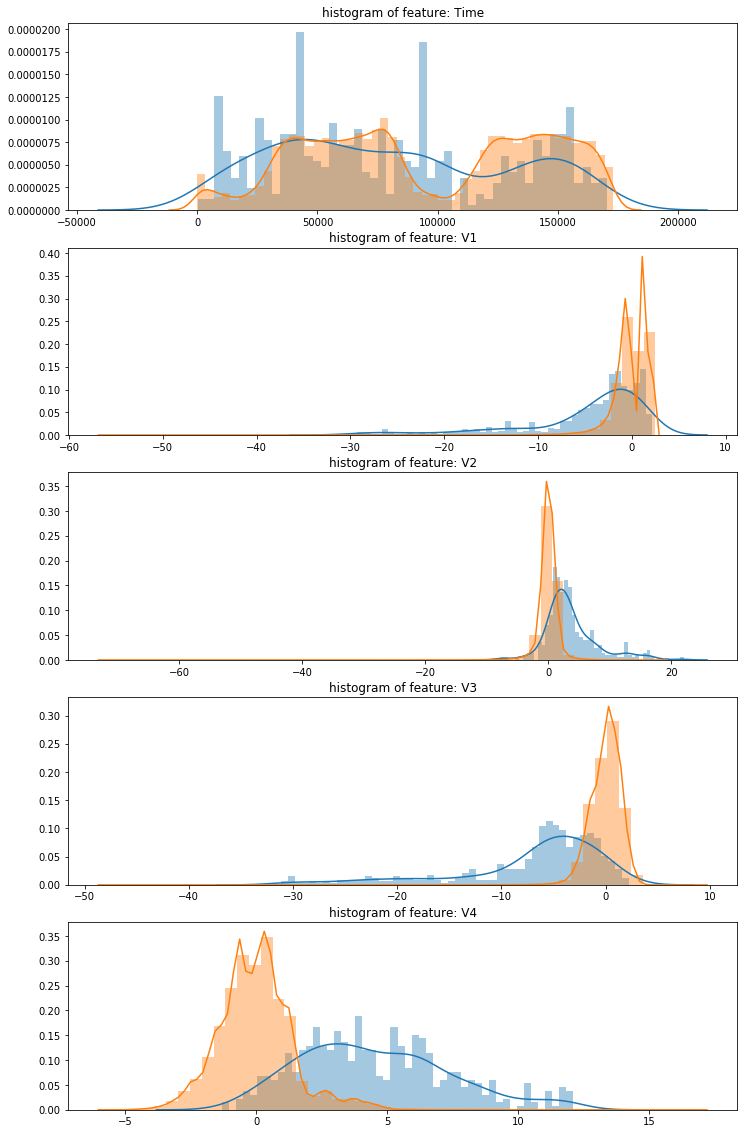

In [21]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5,1)
#print(gs[1])
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [22]:
TEST_RATIO = 0.25
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [23]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

Total train examples: 213605, total fraud cases: 398, equal to 0.00186 of total cases. 


In [24]:
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total test examples: 71202, total fraud cases: 94, equal to 0.00132 of total cases. 


In [25]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

In [26]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

In [27]:
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)

Epoch: 0001 cost= 1.155256510 Train auc= 0.953156 Time elapsed= 0:00:01.412112
Epoch: 0002 cost= 1.282293439 Train auc= 0.954779 Time elapsed= 0:00:02.645318
Epoch: 0003 cost= 1.005930185 Train auc= 0.954828 Time elapsed= 0:00:03.859885
Epoch: 0004 cost= 0.420305461 Train auc= 0.955908 Time elapsed= 0:00:05.070539
Epoch: 0005 cost= 0.448440164 Train auc= 0.956594 Time elapsed= 0:00:06.273771
Epoch: 0006 cost= 0.475942850 Train auc= 0.957085 Time elapsed= 0:00:07.578755
Epoch: 0007 cost= 0.423600584 Train auc= 0.957216 Time elapsed= 0:00:08.858301
Epoch: 0008 cost= 0.493540525 Train auc= 0.956266 Time elapsed= 0:00:10.070104
Epoch: 0009 cost= 0.471792370 Train auc= 0.954285 Time elapsed= 0:00:11.284163
Epoch: 0010 cost= 0.414333552 Train auc= 0.953746 Time elapsed= 0:00:12.529937
Optimization Finished!
Model saved in file: ./temp_saved_model_1layer.ckpt


In [28]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    now = datetime.now()
    saver.restore(sess, save_model)
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
Test auc score: 0.940651


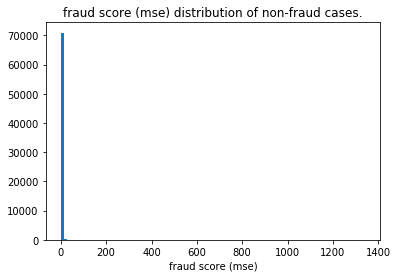

In [29]:
plt.hist(test_batch_mse[test_y == 0.0], bins = 100)
plt.title("fraud score (mse) distribution of non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

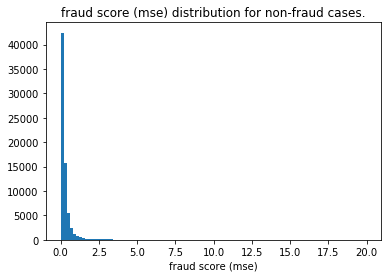

In [30]:
plt.hist(test_batch_mse[(test_y == 0.0) & (test_batch_mse < 20)], bins = 100)
plt.title("fraud score (mse) distribution for non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

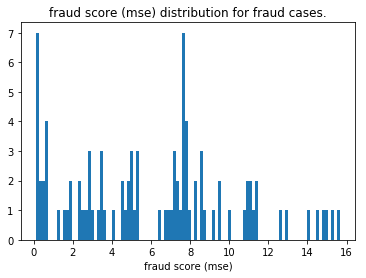

In [31]:
plt.hist(test_batch_mse[test_y == 1.0], bins = 100)
plt.title("fraud score (mse) distribution for fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

In [32]:
THRE_TEST = 7
print("Let's, for example, use 7 as our detection threshold: \n\
Number of detected cases above treshold: {}, \n\
Number of pos cases only above threshold: {}, \n\
The percentage of accuracy above treshold (Precision): {:0.2f}%. \n\
Compared to the average percentage of fraud in test set: 0.132%".format( \
np.sum(test_batch_mse > THRE_TEST), \
np.sum(test_y[test_batch_mse > THRE_TEST]), \
np.sum(test_y[test_batch_mse > THRE_TEST]) / np.sum(test_batch_mse > THRE_TEST) * 100))

Let's, for example, use 7 as our detection threshold: 
Number of detected cases above treshold: 507, 
Number of pos cases only above threshold: 44, 
The percentage of accuracy above treshold (Precision): 8.68%. 
Compared to the average percentage of fraud in test set: 0.132%


In [33]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    saver.restore(sess, save_model)
    
    test_encoding = sess.run(encoder_op, feed_dict={X: test_x})
    train_encoding = sess.run(encoder_op, feed_dict={X: train_x})
    
    print("Dim for test_encoding and train_encoding are: \n", test_encoding.shape, '\n', train_encoding.shape)

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
Dim for test_encoding and train_encoding are: 
 (71202, 15) 
 (213605, 15)


In [34]:
#n_input = test_encoding.shape[1]
n_input = test_encoding.shape[1]

hidden_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden_size])),
    'b2': tf.Variable(tf.zeros([output_size])),
}

hidden_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
pred_logits = tf.add(tf.matmul(hidden_layer, weights['W2']), biases['b2'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(2e-4).minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [35]:
n_epochs = 80
batch_size = 256

# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_encoding[:int(train_encoding.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_encoding.shape[0] * (1-VAL_PERC))]

val_enc_x = train_encoding[int(train_encoding.shape[0] * (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_encoding.shape[0]]

test_enc_y = all_y_bin[train_encoding.shape[0]:]
print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))

# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]

            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 0.024066366 Val auc= 0.253917 Time elapsed= 0:00:00.542211
Epoch: 0002 cost= 0.026983483 Val auc= 0.665075 Time elapsed= 0:00:01.035371
Epoch: 0003 cost= 0.005298947 Val auc= 0.771724 Time elapsed= 0:00:01.515935
Epoch: 0004 cost= 0.003465455 Val auc= 0.799756 Time elapsed= 0:00:01.983730
Epoch: 0005 cost= 0.011416983 Val auc= 0.810597 Time elapsed= 0:00:02.616583
Epoch: 0006 cost= 0.001120545 Val auc= 0.815985 Time elapsed= 0:00:03.104620
Epoch: 0007 cost= 0.005066750 Val auc= 0.824209 Time elapsed= 0:00:03.597163
Epoch: 0008 cost= 0.001687403 Val auc= 0.833107 Time elapsed= 0:00:04.088335
Epoch: 0009 cost= 0.004583339 Val auc= 0.843488 Time elapsed= 0:00:04.591988
Epoch: 0010 cost= 0.000947033 Val auc= 0.855681 Time elapsed= 0:00:05.062725
Epoch: 0011 cost= 0.042835645 Val auc= 0.863133 Time elapsed= 0:00:05.519243
Epoch: 0012 cost= 0.003882135 Val auc= 0.875361 Time elapsed= 0:00:06.004671
Epoch: 0013

In [36]:
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_probs = sess.run(pred_probs, feed_dict={X: test_encoding})
    
    print("\nTest auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))

INFO:tensorflow:Restoring parameters from ./temp_saved_model_FCLayers.ckpt

Test auc score: 0.9480649153400461
